# Wright-Fisher model of mutation and random genetic drift

A Wright-Fisher model has a fixed population size *N* and discrete non-overlapping generations. Each generation, each individual has a random number of offspring whose mean is proportional to the individual's fitness. Each generation, mutation may occur.

## Setup

In [1]:
import numpy as np
try:
    import itertools.izip as zip
except ImportError:
    import itertools

## Make population dynamic model

### Basic parameters

In [2]:
pop_size = 100

In [3]:
seq_length = 10

In [4]:
alphabet = ['A', 'T', 'G', 'C']

In [5]:
base_haplotype = "AAAAAAAAAA"

### Setup a population of sequences

Store this as a lightweight Dictionary that maps a string to a count. All the sequences together will have count *N*.

In [6]:
pop = {}

In [7]:
pop["AAAAAAAAAA"] = 40

In [8]:
pop["AAATAAAAAA"] = 30

In [9]:
pop["AATTTAAAAA"] = 30

In [10]:
pop["AAATAAAAAA"]

30

### Add mutation

Mutations occur each generation in each individual in every basepair.

In [11]:
mutation_rate = 0.005 # per gen per individual per site

Walk through population and mutate basepairs. Use Poisson splitting to speed this up (you may be familiar with Poisson splitting from its use in the [Gillespie algorithm](https://en.wikipedia.org/wiki/Gillespie_algorithm)). 

 * In naive scenario A: take each element and check for each if event occurs. For example, 100 elements, each with 1% chance. This requires 100 random numbers.
 * In Poisson splitting scenario B: Draw a Poisson random number for the number of events that occur and distribute them randomly. In the above example, this will most likely involve 1 random number draw to see how many events and then a few more draws to see which elements are hit.

First off, we need to get random number of total mutations

In [12]:
def get_mutation_count():
    mean = mutation_rate * pop_size * seq_length
    return np.random.poisson(mean)

Here we use Numpy's [Poisson random number](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.poisson.html).

In [13]:
get_mutation_count()

1

We need to get random haplotype from the population.

In [14]:
pop.keys()

['AAAAAAAAAA', 'AAATAAAAAA', 'AATTTAAAAA']

In [15]:
[x/float(pop_size) for x in pop.values()]

[0.4, 0.3, 0.3]

In [16]:
def get_random_haplotype():
    haplotypes = list(pop.keys()) 
    frequencies = [x/float(pop_size) for x in pop.values()]
    total = sum(frequencies)
    frequencies = [x / total for x in frequencies]
    return np.random.choice(haplotypes, p=frequencies)

Here we use Numpy's [weighted random choice](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html).

In [17]:
get_random_haplotype()

'AAAAAAAAAA'

Here, we take a supplied haplotype and mutate a site at random.

In [18]:
def get_mutant(haplotype):
    site = np.random.randint(seq_length)
    possible_mutations = list(alphabet)
    possible_mutations.remove(haplotype[site])
    mutation = np.random.choice(possible_mutations)
    new_haplotype = haplotype[:site] + mutation + haplotype[site+1:]
    return new_haplotype

In [19]:
get_mutant("AAAAAAAAAA")

'AAAAACAAAA'

Putting things together, in a single mutation event, we grab a random haplotype from the population, mutate it, decrement its count, and then check if the mutant already exists in the population. If it does, increment this mutant haplotype; if it doesn't create a new haplotype of count 1. 

In [20]:
def mutation_event():
    haplotype = get_random_haplotype()
    if pop[haplotype] > 1:
        pop[haplotype] -= 1
        new_haplotype = get_mutant(haplotype)
        if new_haplotype in pop:
            pop[new_haplotype] += 1
        else:
            pop[new_haplotype] = 1

In [21]:
mutation_event()

In [22]:
pop

{'AAAAAAAAAA': 40, 'AAATAAAAAA': 29, 'AAATAAGAAA': 1, 'AATTTAAAAA': 30}

To create all the mutations that occur in a single generation, we draw the total count of mutations and then iteratively add mutation events.

In [23]:
def mutation_step():
    mutation_count = get_mutation_count()
    for i in range(mutation_count):
        mutation_event()

In [24]:
mutation_step()

In [25]:
pop

{'AAAAAAAAAA': 39,
 'AAACAAAAAA': 1,
 'AAATAAAAAA': 28,
 'AAATAAAAGA': 1,
 'AAATAAGAAA': 1,
 'AATCTAAAAA': 1,
 'AATTTAAAAA': 29}

### Add genetic drift

Given a list of haplotype frequencies currently in the population, we can take a [multinomial draw](https://en.wikipedia.org/wiki/Multinomial_distribution) to get haplotype counts in the following generation.

In [26]:
def get_offspring_counts():
    haplotypes = list(pop.keys())
    frequencies = [x/float(pop_size) for x in pop.values()]
    return list(np.random.multinomial(pop_size, frequencies))

Here we use Numpy's [multinomial random sample](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multinomial.html).

In [27]:
get_offspring_counts()

[39, 0, 33, 4, 23, 0, 1]

We then need to assign this new list of haplotype counts to the `pop` dictionary. To save memory and computation, if a haplotype goes to 0, we remove it entirely from the `pop` dictionary.

In [28]:
def offspring_step():
    haplotypes = list(pop.keys())
    counts = get_offspring_counts()
    for (haplotype, count) in zip(haplotypes, counts):
        if (count > 0):
            pop[haplotype] = count
        else:
            del pop[haplotype]

In [29]:
offspring_step()

In [30]:
pop

{'AAAAAAAAAA': 36,
 'AAATAAAAAA': 28,
 'AAATAAGAAA': 2,
 'AATCTAAAAA': 2,
 'AATTTAAAAA': 32}

### Combine and iterate

Each generation is simply a mutation step where a random number of mutations are thrown down, and an offspring step where haplotype counts are updated.

In [31]:
def time_step():
    mutation_step()
    offspring_step()

Can iterate this over a number of generations.

In [32]:
generations = 5

In [33]:
def simulate():
    for i in range(generations):
        time_step()

In [34]:
simulate()

In [35]:
pop

{'AAAAAAAAAA': 40,
 'AAAAAAAACA': 1,
 'AAAAAAAAGA': 1,
 'AAAAACAAAA': 2,
 'AAAAACAACA': 2,
 'AAAAACAATA': 1,
 'AAATAAAAAA': 14,
 'AAATAAAAAC': 4,
 'AAATAAAAAG': 2,
 'AAATAAGAAA': 4,
 'AATTTAAAAA': 23,
 'AATTTCAAAA': 3,
 'AATTTGAAAA': 1,
 'ACAAACAACA': 1,
 'AGATAAGAAA': 1}

### Record

We want to keep a record of past population frequencies to understand dynamics through time. At each step in the simulation, we append to a history object.

In [36]:
pop = {"AAAAAAAAAA": pop_size}

In [37]:
history = []

In [38]:
def simulate():
    clone_pop = dict(pop)
    history.append(clone_pop)
    for i in range(generations):
        time_step()
        clone_pop = dict(pop)
        history.append(clone_pop)

In [39]:
simulate()

In [40]:
pop

{'AAAAAAAAAA': 73,
 'AAAAAAAGAA': 7,
 'AAAAAAATAA': 3,
 'AAAAACAAAA': 4,
 'AAAACAAAAA': 2,
 'AAAAGAAAAA': 4,
 'AAATAAAAAA': 1,
 'AAATAAAGAA': 1,
 'AAGAAAAAAA': 1,
 'GAAAAAAAAA': 4}

In [41]:
history[0]

{'AAAAAAAAAA': 100}

In [42]:
history[1]

{'AAAAAAAAAA': 96, 'AAAAAAAAAT': 1, 'AAAAGAAAAA': 1, 'AAATAAAAAA': 2}

In [43]:
history[2]

{'AAAAAAAAAA': 83,
 'AAAAAAAAAT': 2,
 'AAAAAAAACA': 1,
 'AAAAAAAATA': 2,
 'AAAAAAAGAA': 2,
 'AAAAAAATAA': 3,
 'AAAAACAAAA': 3,
 'AAAAGAAAAA': 2,
 'GAAAAAAAAA': 2}

## Analyze trajectories

### Calculate diversity

Here, diversity in population genetics is usually shorthand for the statistic *&pi;*, which measures pairwise differences between random individuals in the population. *&pi;* is usually measured as substitutions per site.

In [44]:
pop

{'AAAAAAAAAA': 73,
 'AAAAAAAGAA': 7,
 'AAAAAAATAA': 3,
 'AAAAACAAAA': 4,
 'AAAACAAAAA': 2,
 'AAAAGAAAAA': 4,
 'AAATAAAAAA': 1,
 'AAATAAAGAA': 1,
 'AAGAAAAAAA': 1,
 'GAAAAAAAAA': 4}

First, we need to calculate the number of differences per site between two arbitrary sequences.

In [45]:
def get_distance(seq_a, seq_b):
    diffs = 0
    length = len(seq_a)
    assert len(seq_a) == len(seq_b)
    for chr_a, chr_b in zip(seq_a, seq_b):
        if chr_a != chr_b:
            diffs += 1
    return diffs / float(length)

In [46]:
get_distance("AAAAAAAAAA", "AAAAAAAAAB")

0.1

We calculate diversity as a weighted average between all pairs of haplotypes, weighted by pairwise haplotype frequency.

In [47]:
def get_diversity(population):
    haplotypes = list(population.keys())
    haplotype_count = len(haplotypes)
    diversity = 0
    for i in range(haplotype_count):
        for j in range(haplotype_count):
            haplotype_a = haplotypes[i]
            haplotype_b = haplotypes[j]
            frequency_a = population[haplotype_a] / float(pop_size)
            frequency_b = population[haplotype_b] / float(pop_size)
            frequency_pair = frequency_a * frequency_b
            diversity += frequency_pair * get_distance(haplotype_a, haplotype_b)
    return diversity

In [48]:
get_diversity(pop)

0.052759999999999974

In [49]:
def get_diversity_trajectory():
    trajectory = [get_diversity(generation) for generation in history]
    return trajectory

In [50]:
get_diversity_trajectory()

[0.0,
 0.0078799999999999999,
 0.033059999999999957,
 0.049079999999999992,
 0.051920000000000008,
 0.052759999999999974]

### Plot diversity

Here, we use [matplotlib](http://matplotlib.org/) for all Python plotting.

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

Here, we make a simple line plot using matplotlib's `plot` function.

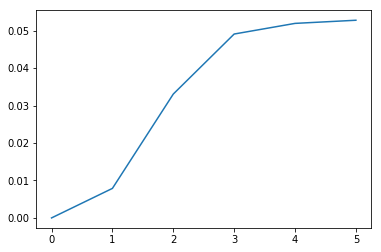

In [52]:
plt.plot(get_diversity_trajectory())

Here, we style the plot a bit with x and y axes labels.

In [53]:
def diversity_plot():
    mpl.rcParams['font.size']=14
    trajectory = get_diversity_trajectory()
    plt.plot(trajectory, "#447CCD")    
    plt.ylabel("diversity")
    plt.xlabel("generation")

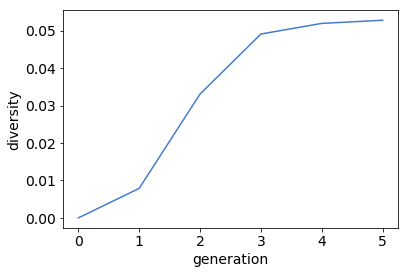

In [54]:
diversity_plot()

### Analyze and plot divergence

In population genetics, divergence is generally the number of substitutions away from a reference sequence. In this case, we can measure the average distance of the population to the starting haplotype. Again, this will be measured in terms of substitutions per site.

In [55]:
def get_divergence(population):
    haplotypes = population.keys()
    divergence = 0
    for haplotype in haplotypes:
        frequency = population[haplotype] / float(pop_size)
        divergence += frequency * get_distance(base_haplotype, haplotype)
    return divergence

In [56]:
def get_divergence_trajectory():
    trajectory = [get_divergence(generation) for generation in history]
    return trajectory

In [57]:
get_divergence_trajectory()

[0.0,
 0.0040000000000000001,
 0.017000000000000001,
 0.026000000000000002,
 0.028000000000000004,
 0.028000000000000004]

In [58]:
def divergence_plot():
    mpl.rcParams['font.size']=14
    trajectory = get_divergence_trajectory()
    plt.plot(trajectory, "#447CCD")
    plt.ylabel("divergence")
    plt.xlabel("generation") 

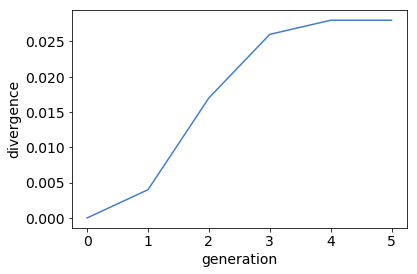

In [59]:
divergence_plot()

### Plot haplotype trajectories

We also want to directly look at haplotype frequencies through time.

In [60]:
def get_frequency(haplotype, generation):
    pop_at_generation = history[generation]
    if haplotype in pop_at_generation:
        return pop_at_generation[haplotype]/float(pop_size)
    else:
        return 0

In [61]:
get_frequency("AAAAAAAAAA", 4)

0.72999999999999998

In [62]:
def get_trajectory(haplotype):
    trajectory = [get_frequency(haplotype, gen) for gen in range(generations)]
    return trajectory

In [63]:
get_trajectory("AAAAAAAAAA")

[1.0,
 0.95999999999999996,
 0.82999999999999996,
 0.73999999999999999,
 0.72999999999999998]

We want to plot all haplotypes seen during the simulation.

In [64]:
def get_all_haplotypes():
    haplotypes = set()   
    for generation in history:
        for haplotype in generation:
            haplotypes.add(haplotype)
    return haplotypes

In [65]:
get_all_haplotypes()

{'AAAAAAAAAA',
 'AAAAAAAAAT',
 'AAAAAAAACA',
 'AAAAAAAATA',
 'AAAAAAAGAA',
 'AAAAAAATAA',
 'AAAAACAAAA',
 'AAAACAAAAA',
 'AAAAGAAAAA',
 'AAATAAAAAA',
 'AAATAAAGAA',
 'AAGAAAAAAA',
 'GAAAAAAAAA'}

Here is a simple plot of their overall frequencies.

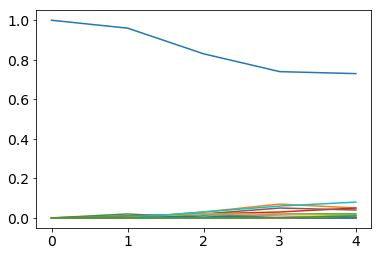

In [66]:
haplotypes = get_all_haplotypes()
for haplotype in haplotypes:
    plt.plot(get_trajectory(haplotype))
plt.show()

In [67]:
colors = ["#781C86", "#571EA2", "#462EB9", "#3F47C9", "#3F63CF", "#447CCD", "#4C90C0", "#56A0AE", "#63AC9A", "#72B485", "#83BA70", "#96BD60", "#AABD52", "#BDBB48", "#CEB541", "#DCAB3C", "#E49938", "#E68133", "#E4632E", "#DF4327", "#DB2122"]

In [68]:
colors_lighter = ["#A567AF", "#8F69C1", "#8474D1", "#7F85DB", "#7F97DF", "#82A8DD", "#88B5D5", "#8FC0C9", "#97C8BC", "#A1CDAD", "#ACD1A0", "#B9D395", "#C6D38C", "#D3D285", "#DECE81", "#E8C77D", "#EDBB7A", "#EEAB77", "#ED9773", "#EA816F", "#E76B6B"]

We can use `stackplot` to stack these trajectoies on top of each other to get a better picture of what's going on.

In [69]:
def stacked_trajectory_plot(xlabel="generation"):
    mpl.rcParams['font.size']=18
    haplotypes = get_all_haplotypes()
    trajectories = [get_trajectory(haplotype) for haplotype in haplotypes]
    plt.stackplot(range(generations), trajectories, colors=colors_lighter)
    plt.ylim(0, 1)
    plt.ylabel("frequency")
    plt.xlabel(xlabel)

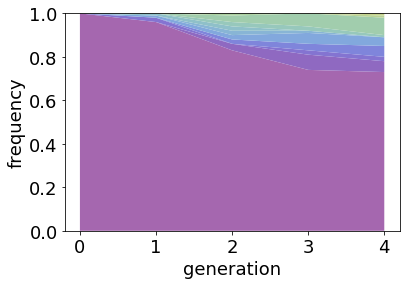

In [70]:
stacked_trajectory_plot()

### Plot SNP trajectories

In [71]:
def get_snp_frequency(site, generation):
    minor_allele_frequency = 0.0
    pop_at_generation = history[generation]
    for haplotype in pop_at_generation.keys():
        allele = haplotype[site]
        frequency = pop_at_generation[haplotype] / float(pop_size)
        if allele != "A":
            minor_allele_frequency += frequency
    return minor_allele_frequency

In [72]:
get_snp_frequency(3, 5)

0.02

In [73]:
def get_snp_trajectory(site):
    trajectory = [get_snp_frequency(site, gen) for gen in range(generations)]
    return trajectory

In [74]:
get_snp_trajectory(3)

[0.0, 0.02, 0.0, 0.02, 0.029999999999999999]

Find all variable sites.

In [75]:
def get_all_snps():
    snps = set()   
    for generation in history:
        for haplotype in generation:
            for site in range(seq_length):
                if haplotype[site] != "A":
                    snps.add(site)
    return snps

In [76]:
def snp_trajectory_plot(xlabel="generation"):
    mpl.rcParams['font.size']=18
    snps = get_all_snps()
    trajectories = [get_snp_trajectory(snp) for snp in snps]
    data = []
    for trajectory, color in zip(trajectories, itertools.cycle(colors)):
        data.append(range(generations))
        data.append(trajectory)    
        data.append(color)
    plt.plot(*data)   
    plt.ylim(0, 1)
    plt.ylabel("frequency")
    plt.xlabel(xlabel)

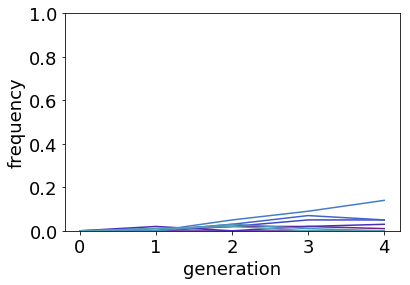

In [77]:
snp_trajectory_plot()

## Scale up

Here, we scale up to more interesting parameter values.

In [78]:
pop_size = 50
seq_length = 100
generations = 500
mutation_rate = 0.0001 # per gen per individual per site

In this case there are $\mu$ = 0.01 mutations entering the population every generation.

In [79]:
seq_length * mutation_rate

0.01

And the population genetic parameter $\theta$, which equals $2N\mu$, is 1.

In [80]:
2 * pop_size * seq_length * mutation_rate

1.0

In [81]:
base_haplotype = ''.join(["A" for i in range(seq_length)])
pop.clear()
del history[:]
pop[base_haplotype] = pop_size

In [82]:
simulate()

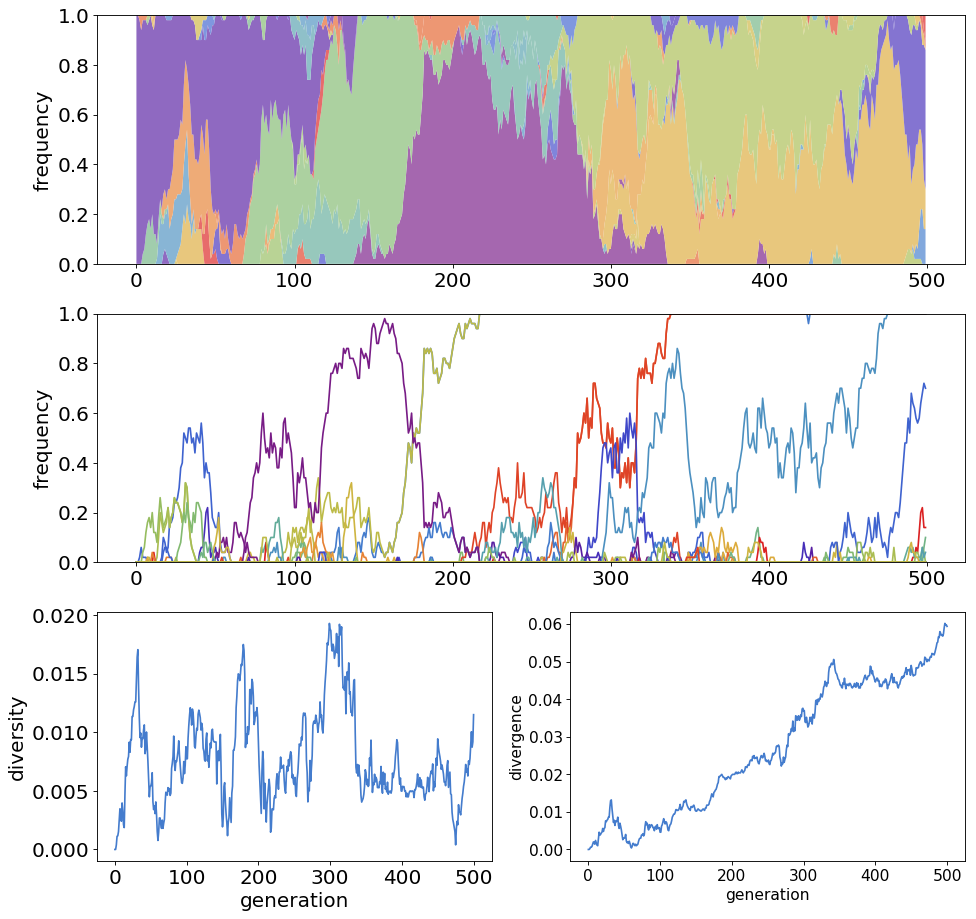

In [83]:
plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
plt.subplot2grid((3,2), (0,0), colspan=2)
stacked_trajectory_plot(xlabel="")
plt.subplot2grid((3,2), (1,0), colspan=2)
snp_trajectory_plot(xlabel="")
plt.subplot2grid((3,2), (2,0))
diversity_plot()
plt.subplot2grid((3,2), (2,1))
divergence_plot()